In [1]:
import pickle
import datetime
import os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np

pickle_in = open("pickles/data.pickle","rb")
data_dict = pickle.load(pickle_in)
pickle_in = open("pickles/tokens.pickle","rb")
token_dict = pickle.load(pickle_in)
VOCAB_SIZE = len(token_dict)
PADDING_INDEX = 0
pickle_in = open("pickles/vectorized_data.pickle","rb")
vectorized_data = pickle.load(pickle_in)
model_dir = "F:/Thesis/modelsCV/"
metrics_dir = "F:/Thesis/modelsCV/metrics/"

def model_format(h,e,l,i):
    return(model_dir+"CV-"+str(h)+"-"+str(e)+"-"+str(l)+"-"+str(i)+".pickle")
def metrics_format(h,e,l,i):
    return(metrics_dir+"CV-metrics-"+str(h)+"-"+str(e)+"-"+str(l)+"-"+str(i)+".pickle")

def datasize_model_format(h,e,l,datasize,i):
    return(model_dir+"CV-"+str(h)+"-"+str(e)+"-"+str(l)+"-"+str(datasize)+"-"+str(i)+".pickle")
def datasize_metrics_format(h,e,l,datasize,i):
    return(metrics_dir+"CV-metrics-"+str(h)+"-"+str(e)+"-"+str(l)+"-"+str(datasize)+"-"+str(i)+".pickle")

In [2]:
from random import shuffle

indices = []
current_index = 0

def shuffle_dataset(datalist):
    global indices
    global current_index
    indices = [i for i in range(len(datalist))]
    shuffle(indices)
    current_index = 0

def get_next(datalist,batch_size=1):
    global current_index
    all_data = []
    if len(datalist) - batch_size < current_index:
        if current_index >= len(datalist):
            return(None)
        else:
            batch_size = len(datalist) - current_index
    
    maxlen = 0
    flat_unpadded_text = []
    
    label = []
    
    for i in range(batch_size):
        [txt,lbl] = datalist[indices[current_index + i]]
        flat_text = flatten_list(txt)
        if(len(flat_text) > maxlen):
            maxlen = len(flat_text)
        flat_unpadded_text.append(flat_text)
        label.append([lbl])
        
    current_index += batch_size
    
    text = []
    for unpadded_txt in flat_unpadded_text:
        text.append(pad(unpadded_txt,maxlen))

    return([text,label])
    
def pad(txt,length):
    while(len(txt) < length):
        txt.append(PADDING_INDEX)
    return(txt)
    
def flatten_list(listoflists):
    resultinglist = []
    for elementarylist in listoflists:
        for element in elementarylist:
            resultinglist.append(element)
    return(resultinglist)


In [3]:
import torch.nn as nn

class BinaryLSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size,layers=3):
        super(BinaryLSTMClassifier, self).__init__()
        
        # 1. Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=layers)
        
        # 3. Dense Layer
        self.hidden2out = nn.Linear(hidden_dim, output_size)
        
        # Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.4)

    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)
        _, (ht, _) = self.lstm(embeddings)

        lstm_output = ht[-1]
        lstm_output = self.dropout_layer(lstm_output)
        final_output = self.hidden2out(lstm_output)
        return final_output

In [4]:
def epoch_metrics(predictions,correct,do_print=True):
    predictions = flatten_list(predictions)
    unlisted_preds = []
    for elem in predictions:
        unlisted_preds.append(elem[0])
        
    correct = flatten_list(correct)
    unlisted_corrects = []
    for elem in correct:
        unlisted_corrects.append(elem[0])
    
    
    classified_preds = []
    for pred in unlisted_preds:
        if pred > 0.5:
            classified_preds.append(1)
        else:
            classified_preds.append(0)
    
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    relevant = 0
    nonrelevant = 0
    
    for current in range(len(unlisted_corrects)):
        if unlisted_corrects[current] == 1:
            relevant += 1
            if classified_preds[current] == 1:
                tp += 1
            else:
                fn += 1
        else:
            nonrelevant += 1
            if classified_preds[current] == 1:
                fp += 1
            else:
                tn += 1
    p = "/"
    r = "/"
    f = 0
    a = round((tp+tn)/(tp+fp+tn+fn),3)
    if relevant != 0:
        r = (tp/relevant)

    if (tp+fp) != 0:
        p = (tp/(tp+fp))
        if (relevant != 0):
            if ((p+r) != 0):
                f =  round(2*(p*r)/(p+r),3)
            r = round(r,2)
        p = round(p,2)
            
    if do_print:
        print("precision: ",p," - recall: ",r," - accuracy: ",a," - f-score: ",f)
    
    return([a,f])   

In [5]:
import torch
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

def label_indices(vector):
    idxs = []
    for i in range(len(vector)):
        if vector[i] == 1:
            idxs.append(i)
    return(idxs)
           

In [6]:
def check_test(model):
    predictions, correct = [], []
    test_iter = vectorized_data["test"]
    shuffle_dataset(test_iter)
    
    batch_size = 25
    print("Try with BS: ",batch_size)
    sigm= nn.Sigmoid()
    #torch.no_grad()
    while(True):
        try:
            stopped = False
            for example in range(1+(len(test_iter)//batch_size)):
                examples = get_next(test_iter, batch_size)
                if examples != None: #happens when train_iter//batch_size is integer
                    pred = model(torch.LongTensor(examples[0]).transpose(0,1).to(device))
                    predictions.append(sigm(pred).data.tolist())
                    correct.append(examples[1])
                stopped = True
            if stopped:
                break
        except RuntimeError:
            batch_size *= 0.8
            batch_size = int(batch_size)
            if batch_size == 0:
                print("Model too large, BS of 1 too big. Skipping")
                break
            print("That's an oopsie. Try with BS: ",batch_size)
            
    print("Development results:")
    [a,f] = epoch_metrics(predictions,correct)
    return([a,f])
    
def check_model(h=100,e=100,l=3,datasize='all',fa='f'):
    a_s = []
    f_s = []
    for i in range(5):
    
        if datasize != 'all':
            pickle_in = open(datasize_model_format(h,e,l,datasize,i),"rb")
        else:
            pickle_in = open(model_format(h,e,l,i),"rb")
        model = pickle.load(pickle_in)
        model.eval()
        [a,f] = check_test(model)
        a_s.append(a)
        f_s.append(f)
    print("### H: ",h," E: ",e, "L: ",l)
    avg_f = round(np.mean(f_s),3)
    std_f = round(np.std(f_s),3)
    avg_a = round(np.mean(a_s),3)
    std_a = round(np.std(a_s),3)
    if fa == 'f' or fa == 'both':
        print(f"average f-score: {avg_f}")
        print(f"standard dev: {round(std_f)}")
    if fa == 'a' or fa == 'both':
        print(f"average accuracy: {avg_a}")
        print(f"standard dev: {std_a}")
    return([avg_f,std_f,avg_a,std_a])

In [7]:
def get_fs_as(h,e,l,i):
    a_s = []
    f_s = []
    pickle_in = open(metrics_format(h,e,l,i),"rb")
    tmp = pickle.load(pickle_in)

    if len(tmp) == 2:
        [f_s,a_s] = tmp
    else:
        f_s = tmp
    return([f_s, a_s])

def show_list(lstoflsts,name,h,e,l):
    maxes = []
    ends = []
    for [lst,lbl] in lstoflsts:
        if len(lst) != 0:
            maxes.append(max(lst))
            ends.append(lst[-1])
            plt.plot(lst, label=lbl)
    print(f"Best {name} was {round(max(maxes),3)}")
    print(f"On average, {name} ended in {round(np.mean(ends),3)}")
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.title(f"{name} for H:{h}, E:{e}, L:{l}")
    previous = plt.ylim()
    plt.ylim(0,1)
    #plt.ylim(previous[0],1)
    #plt.ylim(0.83,0.92)
    plt.legend()
    plt.show()

def analyze_CV(h,e,l,fa='both',show=False,printer=False,without=[]):
    prev_fs = []
    prev_as = []
    if printer:
        print("### H: ",h," E: ",e, "L: ",l)
    max_fs = []
    try:
        for i in range(5):
            if i not in without:
                [f_s,a_s] = get_fs_as(h,e,l,i)
                prev_as.append([a_s,str(i)])
                prev_fs.append([f_s,str(i)])
        for [fs,lbl] in prev_fs:
            max_fs.append(max(fs))
        if printer:
            print(f"average f-score: {round(np.mean(max_fs),3)}")
            print(f"standard dev: {round(np.std(max_fs),3)}")
        if show:
            if fa == "f" or fa == "both":
                show_list(prev_fs,"f-score",h,e,l)
            if fa == "a" or fa == "both":
                show_list(prev_as,"accuracy",h,e,l)
    except (FileNotFoundError,EOFError) as e:
        if printer:
            print("File error: ",e)
        return
    return([round(np.mean(max_fs),3),round(np.std(max_fs),3)])


In [8]:
def show_errorbars(data,title="",dep="Dependent Variable",indep="Independent variable",savename = '', limit_ticks = False):
    for [avg,std,lbl] in data:
        plt.errorbar(lbl, avg, std, marker='o', mec='blue', mfc='blue', color='blue',ms=5)
    plt.ylabel(dep)
    plt.xlabel(indep)
    plt.title(title)
    previous = plt.ylim()
    plt.ylim(0.75,0.95)
    #plt.ylim(previous[0],0.95)
    
    # plt.xlim(0,400)
    if limit_ticks:
        xint = range(1,4)
        plt.xticks(xint)
    if savename != '':
        plt.savefig('images/errors/'+savename+'.pdf')
    plt.show()
    
def show_embedding_influence(l=3):
    for h in [50,100,150,200,250,300]:
        datas = []
        for e in [50,100,150,200,250,300]:
            try:
                [avg,std] = analyze_CV(h,e,l,fa='both',show=False,printer=False,without=[])
                datas.append([avg,std,e])
            except TypeError:
                pass
        if len(datas) != 0:
            show_errorbars(datas,title=f'F-score distribution for h={h}, {l}-layer LSTM',dep="F-score",indep=f'Embedding dimension size',savename=f'layer{l}-hidden{h}')
            
def show_hidden_influence(l=3):
    for e in [50,100,150,200,250,300]:
        datas = []
        for h in [50,100,150,200,250,300]:
            try:
                [avg,std] = analyze_CV(h,e,l,fa='both',show=False,printer=False,without=[])
                datas.append([avg,std,h])
            except TypeError:
                pass
        if len(datas) != 0:
            show_errorbars(datas,title=f'F-score distribution for e={e}, {l}-layer LSTM',dep="F-score",indep=f'Hidden dimension size',savename=f'layer{l}-embedding{e}')
            
def show_layer_influence():
    for e in [250,300]:
        for h in [250,300]:
            datas = []
            for l in [1,2,3]:
                try:
                    [avg,std] = analyze_CV(h,e,l,fa='both',show=False,printer=False,without=[])
                    datas.append([avg,std,l])
                except TypeError:
                    pass
            if len(datas) != 0:
                show_errorbars(datas,title=f'F-score distribution for e={e},h={h}',dep="F-score",indep=f'# of LSTM-layers',savename=f'layers-hidden{h}-embedding{e}',limit_ticks = True)
    for e in [250]:
        for h in [150]:
            datas = []
            for l in [1,2,3]:
                try:
                    [avg,std] = analyze_CV(h,e,l,fa='both',show=False,printer=False,without=[])
                    datas.append([avg,std,l])
                except TypeError:
                    pass
            if len(datas) != 0:
                show_errorbars(datas,title=f'F-score distribution for e={e},h={h}',dep="F-score",indep=f'# of LSTM-layers',savename=f'layers-hidden{h}-embedding{e}', limit_ticks = True)


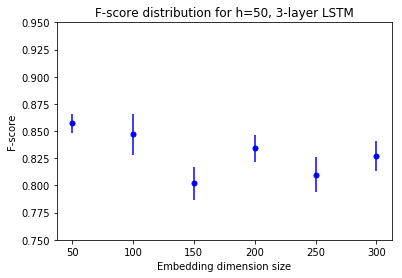

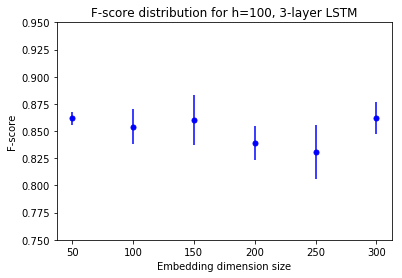

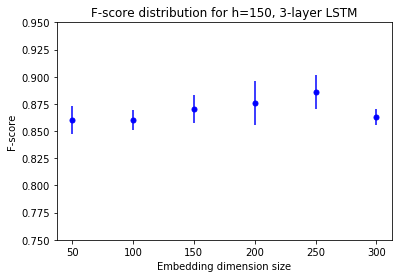

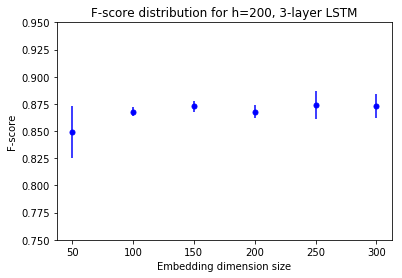

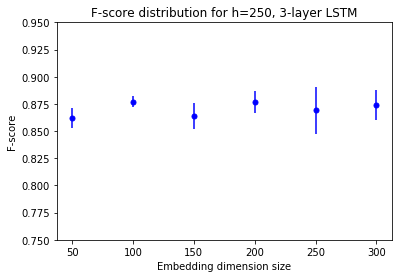

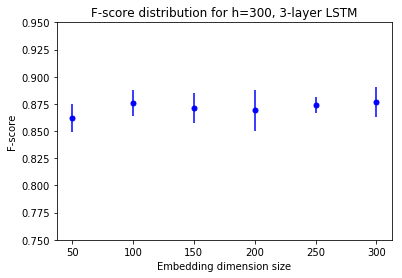

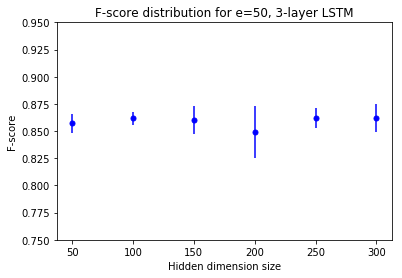

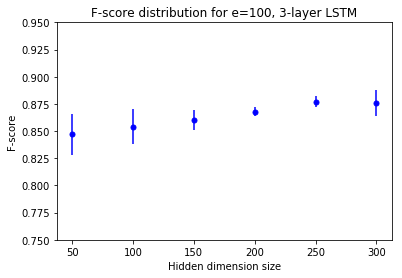

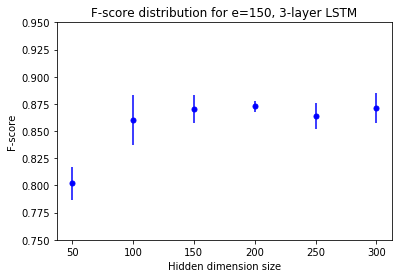

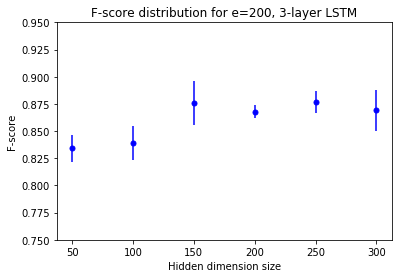

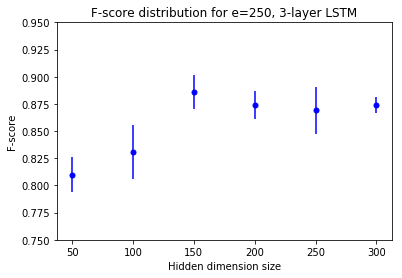

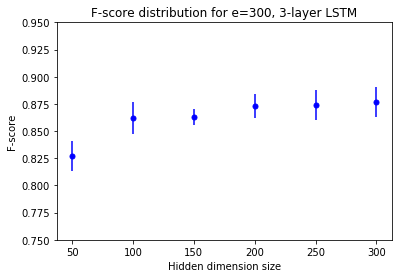

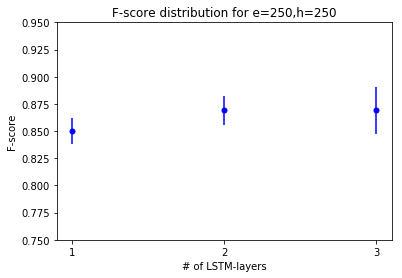

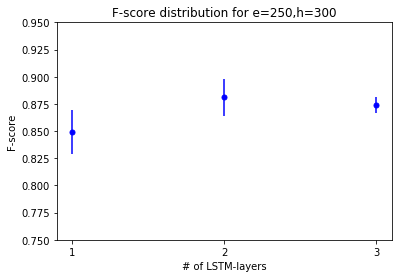

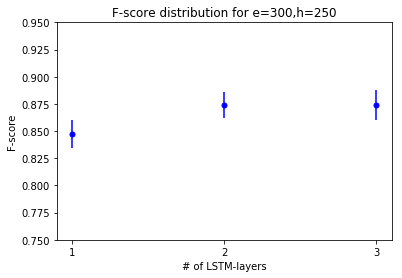

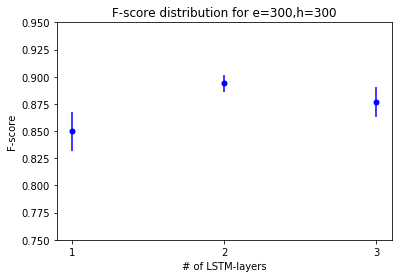

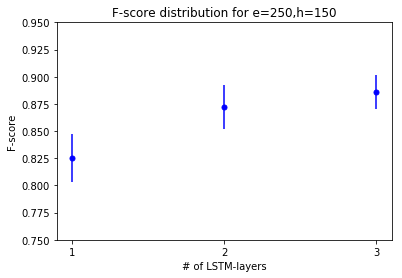

In [9]:
show_embedding_influence()
show_hidden_influence()
show_layer_influence()

In [9]:
# [50,100,150,200,250,300]

hidden_dims = []#[50,100,150,200,250,300]
embedding_dims = []#[50,100,150,200,250,300]
layer_amounts = []#[1,2,3]

for l in layer_amounts:
    for h in hidden_dims:
        for e in embedding_dims:
            try:
                analyze_CV(h,e,l,printer=True,fa='f')
            except ValueError:
                pass

hidden = 300
embedding = 300
layers = 2
datasizes = [50,100,150,500,1000,1500,5000,10000,15000,'all']
results_avg = []
results_std = []
for amount in datasizes:
    print(f"h: {hidden}, e: {embedding},l: {layers},datasize: {amount}")
    [avg_f,std_f,avg_a,std_a] = check_model(h=hidden,e=embedding,l=layers,datasize=amount,fa='a')
    results_avg.append(avg_a)
    results_std.append(std_a)
print(results_avg)
print(results_std)
hidden = 300
embedding = 300
layers = 3
datasizes = [50,100,150,500,1000,1500,5000,10000,15000,'all']

results_avg = []
results_std = []
for amount in datasizes:
    print(f"h: {hidden}, e: {embedding},l: {layers},datasize: {amount}")
    [avg_f,std_f,avg_a,std_a] = check_model(h=hidden,e=embedding,l=layers,datasize=amount,fa='a')
    results_avg.append(avg_a)
    results_std.append(std_a)
print(results_avg)
print(results_std)

h: 300, e: 300,l: 2,datasize: 50
Try with BS:  25


C:\Users\n8\Anaconda3\envs\ulmfit\lib\site-packages\torch\nn\modules\rnn.py:179: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Development results:
precision:  0.49  - recall:  0.48  - accuracy:  0.488  - f-score:  0.485
Try with BS:  25
Development results:
precision:  0.5  - recall:  0.68  - accuracy:  0.499  - f-score:  0.577
Try with BS:  25
Development results:
precision:  0.49  - recall:  0.43  - accuracy:  0.489  - f-score:  0.455
Try with BS:  25
Development results:
precision:  0.49  - recall:  0.64  - accuracy:  0.489  - f-score:  0.556
Try with BS:  25
Development results:
precision:  0.5  - recall:  0.58  - accuracy:  0.494  - f-score:  0.536
### H:  300  E:  300 L:  2
average accuracy: 0.492
standard dev: 0.004
h: 300, e: 300,l: 2,datasize: 100
Try with BS:  25
Development results:
precision:  0.53  - recall:  0.51  - accuracy:  0.533  - f-score:  0.524
Try with BS:  25
Development results:
precision:  0.51  - recall:  0.66  - accuracy:  0.512  - f-score:  0.575
Try with BS:  25
Development results:
precision:  0.55  - recall:  0.36  - accuracy:  0.533  - f-score:  0.439
Try with BS:  25
Developme